<a href="https://colab.research.google.com/github/SeungGi-5/JEJU/blob/main/%EC%A0%9C%EC%A3%BCnews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.font_manager as fm
!apt-get update -qq 
!apt-get install fonts-nanum* -qq
fm._rebuild()

! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git 
% cd Mecab-ko-for-Google-Colab 
! bash install_mecab-ko_on_colab190912.sh

Selecting previously unselected package fonts-nanum.
(Reading database ... 148486 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumeratin

In [ ]:
"""! pip install --target=$my_path kss
! pip install --target=$my_path umap-learn
! pip install --target=$my_path pyLDAvis
! pip install --target=$my_path hdbscan
! pip install --target=$my_path apyori
! pip install --target=$my_path glove-python-binary"""
! pip install pynndescent

  Using cached pynndescent-0.5.4-py3-none-any.whl


In [ ]:
import os, sys 
from google.colab import drive 
drive.mount('/content/drive')
my_path = '/content/notebooks' 
#os.symlink('/content/drive/My Drive/Colab Notebooks/env', my_path) 
sys.path.insert(0,my_path) 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import kss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from konlpy.tag import Mecab
import re
from glove import Glove
from glove.corpus import Corpus

from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

import umap
import hdbscan

# 뉴스기사 로드

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/제주news_text.csv')

In [ ]:
df.rename(columns={'0':'text'},inplace=True)

# 문장 토큰화

In [ ]:
en=['’','‘','“','”','"']
for i in df.index:
    for y in en:
        df.loc[i,'text']=df.loc[i,'text'].replace(y,'')

In [ ]:
t=[]
for i,v in enumerate(df.index):
    t.append(kss.split_sentences((df.loc[v,'text']),use_heuristic=False))

In [ ]:
df['sent']=t

In [ ]:
df

,text,sent
0,제주 하루새 55명... 최다 확진자 하루만에 깨져 제주지역 코로나19 역대 확진자...,[제주 하루새 55명... 최다 확진자 하루만에 깨져 제주지역 코로나19 역대 확진...
1,"제주 중학생 살해 백광석·김시남, 법의 심판대로 제주 조천읍에서 중학생을 살해한 혐...","[제주 중학생 살해 백광석·김시남, 법의 심판대로 제주 조천읍에서 중학생을 살해한 ..."
2,제주 이틀 연속 40명 넘어... 누적 2천명 돌파 제주에서는 코로나19 확진자 수...,"[제주 이틀 연속 40명 넘어..., 누적 2천명 돌파 제주에서는 코로나19 확진자..."
3,"안동우 시장, 굿네이버스 꿈지원단에 1호로 참여 안동우 제주시장은 굿네이버스 제주지...","[안동우 시장, 굿네이버스 꿈지원단에 1호로 참여 안동우 제주시장은 굿네이버스 제주..."
4,"제주 어린이집 아동학대, 검찰 실형 내려달라 제주시내 한 어린이집에서 다수의 아동들...","[제주 어린이집 아동학대, 검찰 실형 내려달라 제주시내 한 어린이집에서 다수의 아동..."
...,...,...
23380,2019년 하반기 제주시 공직자 48명 퇴임 제주시는 31일자로 퇴임하는 공직자를 ...,[2019년 하반기 제주시 공직자 48명 퇴임 제주시는 31일자로 퇴임하는 공직자를...
23381,"도교육청, 2020학년도 공립(사립포함) 중등임용 후보자 1차 시헙 합격자 공고 제...","[도교육청, 2020학년도 공립(사립포함) 중등임용 후보자 1차 시헙 합격자 공고 ..."
23382,"서귀포시, 위생업소 고충상담실 운영...만족도 96.9% 서귀포시에서는 소규모 위생...","[서귀포시, 위생업소 고충상담실 운영...만족도 96.9% 서귀포시에서는 소규모 위..."
23383,"유종성, 고창덕 등 제주 공직자 46명 정년퇴임 짧게는 13년, 길게는 41년 동안...","[유종성, 고창덕 등 제주 공직자 46명 정년퇴임 짧게는 13년, 길게는 41년 동..."


# 단어 토큰화 및 전처리

In [ ]:
stopwords=list(pd.read_table('/content/drive/MyDrive/한국어불용어100.txt')['word'])

In [ ]:
mecab=Mecab()

In [ ]:
def word_token(sents):
    return [mecab.morphs(sent) for sent in sents]
def proce(sent):
    sent=[re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣\s]','',word) for word in sent]
    return [word for word in sent if word not in stopwords and word and len(word)>1]
def proce_sent(sents):
    return [proce(sent) for sent in sents]

In [ ]:
df['token']=df['sent'].apply(word_token)

In [ ]:
df['token']=df['token'].apply(proce_sent)

# 전체 문장에 대한 임베딩을 위한 리스트

In [ ]:
token_list=[]
for i in df.token:
    for y in i:
        token_list.append(y)

In [ ]:
len(token_list)

171460

# Glove를 이용한 임베딩

In [ ]:
corpus=Corpus()

In [ ]:
corpus.fit(token_list,window=10)

In [ ]:
glove=Glove(no_components=128,learning_rate=0.01)
glove.fit(corpus.matrix,epochs=30,no_threads=4,verbose=True)
glove.add_dictionary(corpus.dictionary)
glove.save('/content/drive/MyDrive/Colab Notebooks/model/glove.model')

Performing 30 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [ ]:
glove=Glove.load('/content/drive/MyDrive/Colab Notebooks/model/glove.model')

In [ ]:
# 뉴스기사 문서별 임베딩을 위한 과정
glove_dict={}
for word in glove.dictionary.keys():
    glove_dict[word]=glove.word_vectors[glove.dictionary[word]]

# 전체 문장에 대한 임베딩을 통한 문서(뉴스기사)별 임베딩 추출

In [ ]:
df

,text,sent,token,Embedding,SimMatrix,score,summary
0,제주 하루새 55명... 최다 확진자 하루만에 깨져 제주지역 코로나19 역대 확진자...,[제주 하루새 55명... 최다 확진자 하루만에 깨져 제주지역 코로나19 역대 확진...,"[[제주, 하루, 새, 최다, 확진, 자, 하루, 만, 에, 깨져, 제주, 지역, ...","[[0.056194480888009456, -0.05358741804631471, ...","[[1.0, 0.9771966888305599, 0.8882037365774416,...","{0: 0.05588671547502067, 1: 0.0567901231963105...",전날 새로 발생한 신규 집단감염 사례인 제주시 지인모임 8과 관련해서도 관련 확진자...
1,"제주 중학생 살해 백광석·김시남, 법의 심판대로 제주 조천읍에서 중학생을 살해한 혐...","[제주 중학생 살해 백광석·김시남, 법의 심판대로 제주 조천읍에서 중학생을 살해한 ...","[[제주, 중학생, 살해, 백광석, 김시남, 법, 의, 심판대, 로, 제주, 조천읍...","[[0.012036259488049417, -0.014033919184278982,...","[[0.9999999999999999, 0.7735923709702004, 0.60...","{0: 0.040164619515453984, 1: 0.047218419651385...",제주지검은 백광석이 살인 사건 발생 전 피해자 A군 집에 침입했던 여러 사안에 대해...
2,제주 이틀 연속 40명 넘어... 누적 2천명 돌파 제주에서는 코로나19 확진자 수...,"[제주 이틀 연속 40명 넘어..., 누적 2천명 돌파 제주에서는 코로나19 확진자...","[[제주, 이틀, 연속, 넘, 어], [누적, 천, 돌파, 제주, 에서, 는, 코로...","[[0.014162904429472625, -0.04669533297213278, ...","[[0.9999999999999999, 0.9212881522815566, 0.81...","{0: 0.08054226159798186, 1: 0.0931573228428822...",제주시 노인주간보호센터 관련 확진자가 6명 더 추가되면서 관련 확진자는 29명으로 ...
3,"안동우 시장, 굿네이버스 꿈지원단에 1호로 참여 안동우 제주시장은 굿네이버스 제주지...","[안동우 시장, 굿네이버스 꿈지원단에 1호로 참여 안동우 제주시장은 굿네이버스 제주...","[[안동우, 시장, 굿, 네이버스, 꿈, 원단, 에, 호, 로, 참여, 안동우, 제...","[[0.032223419300083565, -0.03768488961732375, ...","[[1.0000000000000002, 0.9626028915725399, 0.81...","{0: 0.13852455650013737, 1: 0.1419470838377814...","굿네이버스제주지부는 해당 사업에 안동우 제주시장을 꿈지원단 제1호로 선정하고, 10..."
4,"제주 어린이집 아동학대, 검찰 실형 내려달라 제주시내 한 어린이집에서 다수의 아동들...","[제주 어린이집 아동학대, 검찰 실형 내려달라 제주시내 한 어린이집에서 다수의 아동...","[[제주, 어린이집, 아동, 학대, 검찰, 실형, 내려, 달, 라, 제주, 시내, ...","[[0.015623620511095395, -0.012715135079869282,...","[[0.9999999999999998, 0.8761274800744525, 0.79...","{0: 0.05976645611597647, 1: 0.0586526959695106...",그러면서 피고인들은 모든 일과와 모든 장소에서 의도적이고 일상적으로 아동들을 학대했...
...,...,...,...,...,...,...,...
23380,2019년 하반기 제주시 공직자 48명 퇴임 제주시는 31일자로 퇴임하는 공직자를 ...,[2019년 하반기 제주시 공직자 48명 퇴임 제주시는 31일자로 퇴임하는 공직자를...,"[[하반기, 제주시, 공직자, 퇴임, 제주, 시, 는, 일자, 로, 퇴임, 는, 공...","[[0.029808552747461012, -0.06282770435385208, ...","[[0.9999999999999999, 0.9446147016017012, 0.96...","{0: 0.20187541683415772, 1: 0.1984002198969974...",2019년 하반기 제주시 공직자 48명 퇴임 제주시는 31일자로 퇴임하는 공직자를 ...
23381,"도교육청, 2020학년도 공립(사립포함) 중등임용 후보자 1차 시헙 합격자 공고 제...","[도교육청, 2020학년도 공립(사립포함) 중등임용 후보자 1차 시헙 합격자 공고 ...","[[도, 교육청, 학년도, 공립, 사립, 포함, 임용, 후보자, 차, 시, 헙, 합...","[[0.021129166214229275, -0.03531334145588202, ...","[[1.0, 0.8499200760725566, 0.8125945024699553,...","{0: 0.1960084123223756, 1: 0.19649395107970113...","1차 시험 합격자에 한해 2차 시험 응시자격을 부여하며, 2차 시험은 2020년 1..."
23382,"서귀포시, 위생업소 고충상담실 운영...만족도 96.9% 서귀포시에서는 소규모 위생...","[서귀포시, 위생업소 고충상담실 운영...만족도 96.9% 서귀포시에서는 소규모 위...","[[서귀포시, 위생, 업소, 고, 충상, 담, 실, 운영, 만족, 도, 서귀포시, ...","[[0.015609835556136459, -0.045318386528681344,...","[[1.0, 0.9677620389715716, 0.9817236924216836,...","{0: 0.20221657505535046, 1: 0.1998464584389798...","서귀포시, 위생업소 고충상담실 운영...만족도 96.9% 서귀포시에서는 소규모 위생..."
23383,"유종성, 고창덕 등 제주 공직자 46명 정년퇴임 짧게는 13년, 길게는 41년 동안...","[유종성, 고창덕 등 제주 공직자 46명 정년퇴임 짧게는 13년, 길게는 41년 동...","[[유종성, 고, 창덕, 제주, 공직자, 정년, 퇴임, 짧, 게, 는, 길, 게, ...","[[0.012495887466133655, -0.019738350208901904,...","[[1.0000000000000002, 0.8838149899585288, 0.55...","{0: 0.11301303736028907, 1: 0.1163114490420615...",이들 중 유종성 전 도민안전실장과 고창덕 전 의회사무처장은 홍조근정훈장을 받고 정년...


In [ ]:
zero_vector=np.zeros(128)

In [ ]:
def sent_vector(sent):
    if len(sent) != 0:
        return sum([glove_dict.get(w,zero_vector) for w in sent])/len(sent)
    else:
        return zero_vector

In [ ]:
def sent_to_vector(sents):
    return [sent_vector(sent) for sent in sents]

In [ ]:
df['Embedding']=df['token'].apply(sent_to_vector)
df[['Embedding']]

,Embedding
0,"[[0.056194480888009456, -0.05358741804631471, ..."
1,"[[0.012036259488049417, -0.014033919184278982,..."
2,"[[0.014162904429472625, -0.04669533297213278, ..."
3,"[[0.032223419300083565, -0.03768488961732375, ..."
4,"[[0.015623620511095395, -0.012715135079869282,..."
...,...
23380,"[[0.029808552747461012, -0.06282770435385208, ..."
23381,"[[0.021129166214229275, -0.03531334145588202, ..."
23382,"[[0.015609835556136459, -0.045318386528681344,..."
23383,"[[0.012495887466133655, -0.019738350208901904,..."


# 문장 벡터의 코사인 유사도 행렬

In [ ]:
def similarity(sent_embedding):
    matrix=np.zeros([len(sent_embedding),len(sent_embedding)])
    for i in range(len(sent_embedding)):
        for j in range(len(sent_embedding)):
            matrix[i][j]=cosine_similarity(sent_embedding[i].reshape(1,128),
                                           sent_embedding[j].reshape(1,128))[0,0]
    return matrix

In [ ]:
df['SimMatrix']=df['Embedding'].apply(similarity)
df[['SimMatrix']]

,SimMatrix
0,"[[1.0, 0.9771966888305599, 0.8882037365774416,..."
1,"[[0.9999999999999999, 0.7735923709702004, 0.60..."
2,"[[0.9999999999999999, 0.9212881522815566, 0.81..."
3,"[[1.0000000000000002, 0.9626028915725399, 0.81..."
4,"[[0.9999999999999998, 0.8761274800744525, 0.79..."
...,...
23380,"[[0.9999999999999999, 0.9446147016017012, 0.96..."
23381,"[[1.0, 0.8499200760725566, 0.8125945024699553,..."
23382,"[[1.0, 0.9677620389715716, 0.9817236924216836,..."
23383,"[[1.0000000000000002, 0.8838149899585288, 0.55..."


In [ ]:
print('세번째 샘플의 문장 개수 :',len(df['token'][2]))
print('세번째 샘플의 문장 벡터가 모인 문장 행렬의 크기(shape) :',np.shape(df['Embedding'][2]))
print('세번째 샘플의 유사도 행렬의 크기(shape) :',df['SimMatrix'][2].shape)

세번째 샘플의 문장 개수 : 11
세번째 샘플의 문장 벡터가 모인 문장 행렬의 크기(shape) : (11, 128)
세번째 샘플의 유사도 행렬의 크기(shape) : (11, 11)


In [ ]:
def draw_nx(matrix):
    nx_graph=nx.from_numpy_array(matrix)
    plt.figure(figsize=(16,12))
    pos=nx.layout.spiral_layout(nx_graph)
    nx.draw(nx_graph,with_labels=True,font_weight='bold',pos=pos)
    nx.draw_networkx_edge_labels(nx_graph,pos,font_color='red')
    plt.show()

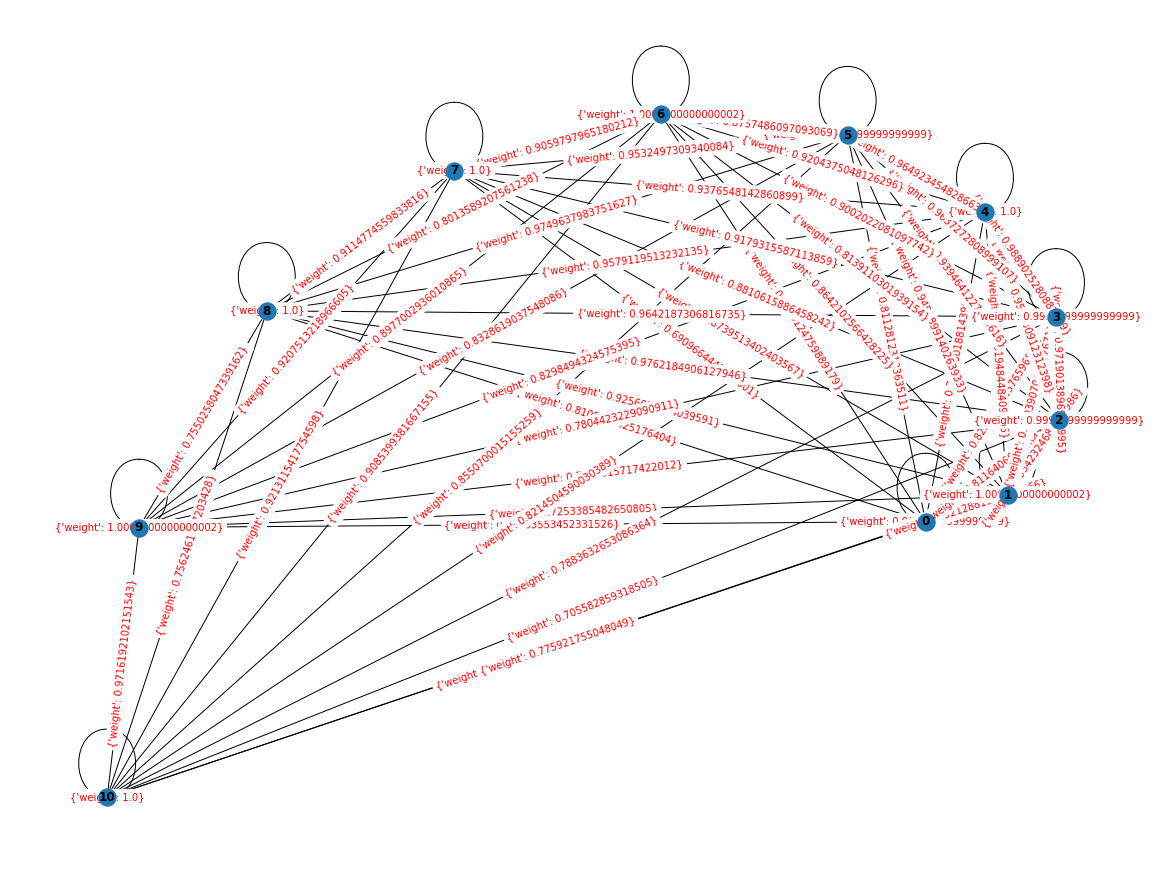

In [ ]:
draw_nx(df['SimMatrix'][2])

# PageRank 알고리즘을 이용하여 각 문장별 score 산출

In [ ]:
def sim_score(matrix):
    nx_graph=nx.from_numpy_array(matrix)
    scores = nx.pagerank_numpy(nx_graph)
    return scores

In [ ]:
df['score']=df['SimMatrix'].apply(sim_score)
df[['SimMatrix','score']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: networkx.pagerank_numpy is deprecated and will be removed in NetworkX 3.0, use networkx.pagerank instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,SimMatrix,score
0,"[[1.0, 0.9771966888305599, 0.8882037365774416,...","{0: 0.05588671547502067, 1: 0.0567901231963105..."
1,"[[0.9999999999999999, 0.7735923709702004, 0.60...","{0: 0.040164619515453984, 1: 0.047218419651385..."
2,"[[0.9999999999999999, 0.9212881522815566, 0.81...","{0: 0.08054226159798186, 1: 0.0931573228428822..."
3,"[[1.0000000000000002, 0.9626028915725399, 0.81...","{0: 0.13852455650013737, 1: 0.1419470838377814..."
4,"[[0.9999999999999998, 0.8761274800744525, 0.79...","{0: 0.05976645611597647, 1: 0.0586526959695106..."
...,...,...
23380,"[[0.9999999999999999, 0.9446147016017012, 0.96...","{0: 0.20187541683415772, 1: 0.1984002198969974..."
23381,"[[1.0, 0.8499200760725566, 0.8125945024699553,...","{0: 0.1960084123223756, 1: 0.19649395107970113..."
23382,"[[1.0, 0.9677620389715716, 0.9817236924216836,...","{0: 0.20221657505535046, 1: 0.1998464584389798..."
23383,"[[1.0000000000000002, 0.8838149899585288, 0.55...","{0: 0.11301303736028907, 1: 0.1163114490420615..."


In [ ]:
df['score'][2]

{0: 0.08054226159798186,
 1: 0.09315732284288221,
 2: 0.09194710836579716,
 3: 0.09482676996867388,
 4: 0.09474673629589575,
 5: 0.09529890310971616,
 6: 0.09053265043343407,
 7: 0.09366792990213829,
 8: 0.09300304104195813,
 9: 0.08549914072385233,
 10: 0.08677813571767025}

# 가장 상위의 점수를 갖는 문장 n개만을 반환 (추출할 요약문)

In [ ]:
def ranked_sents(sents,scores,n=3):
    top_scores=sorted(((scores[i],s)
    for i,s in enumerate(sents)),reverse=True)
    top_n_sents=[sent for score,sent in top_scores[:n]]
    return " ".join(top_n_sents)

In [ ]:
df['summary']=df.apply(lambda x: ranked_sents(x.sent, x.score),axis=1)

In [ ]:
for i in range(10):
    print(i+1,'번 뉴스')
    print('원문 :',df.loc[i].text,'\n')
    print('요약 :',df.loc[i].summary,'\n')

1 번 뉴스
원문 : 제주 하루새 55명... 최다 확진자 하루만에 깨져 제주지역 코로나19 역대 확진자 수가 하루만에 또 다시 깨졌다. 지난 12일(목) 제주에서는 44명의 확진자가 나오면서 역대 최다를 기록하더니 이튿날인 13일(금) 하루 동안 55명이 확진 판정을 받으면서 하루 만에 최다 규모를 경신했다. 8월 들어서는 총 287명이 확진된 것으로 집계됐는데, 이대로라면 이달 일별 최다 확진자에 이어 월별 최다 확진자가 나올 가능성이 매우 농후해졌다. 14일(토) 제주특별자치도에 따르면신규 확진자 55명 중 38명은 제주지역 확진자의 접촉자이며, 1명은 타 지역 확진자의 접촉자로 파악됐다. 나머지 16명은 코로나19 유증상으로 검사를 받고 확진된 사례다. 특히 신규 확진자 중 절반 수준인 26명은 최근 연쇄적으로 터져 나오는집단감염 사례와 관련이 있는 확진자로 파악됐다. 제주시 노인주간보호센터 관련 확진자가 7명 추가되면서관련 확진자는 30명으로 늘었으며, 제주시 직장 5관련 확진자도38명으로 급증했다.또제주시 음식점 3 관련 확진자도10명으로 늘었다. 전날 새로 발생한 신규 집단감염 사례인 제주시 지인모임 8과 관련해서도 관련 확진자가 추가되면서 14일 오전 11시 현재까지 제주시 지인모임 8관련 확진자는 총 24명으로 급증했다. 집단감염 관련 확진자 26명을 제외한 제주지역 확진자의 접촉자 12명은 개별 사례로, 가정·직장 등 일상공간에서 선행 확진자와 만남 등을 통해 바이러스가 전파된 것으로 추정되고 있다. 제주지역8개 초·중·고교에서도 학생 및 교직원 18명이 확진된 것으로 파악됐다. 제주를 포함해 전국적으로 4차 대유행이 본격화되면서 확진자 수가 증가하는 양상을 보이고 있는데 이 추세가 이어진다면제주는 이달 역대 최악의 달로 기록될 가능성이 커졌다. 지난7월의 경우 일일(34명) 최다 확진자에 이어 월별(487명) 최다 확진자가 나온 달로 기록된 바 있다. 그러나 이미 일별 최다 확진자(55명)는 경신됐고 월별 최다 확진자만 남은 셈인데,8월 들

In [ ]:
df.to_csv('/content/drive/MyDrive/뉴스_추출.csv',index=False)

In [ ]:
news=df.summary.values

In [ ]:
len(news)

23385

In [ ]:
text_list=[]
for i in news:
    text=mecab.nouns(i)
    txt=[]
    for y in text:
        if len(y)>1:
            txt.append(y)
    text_list.append(txt)

In [ ]:
text_list

[['전날',
  '발생',
  '신규',
  '집단',
  '감염',
  '사례',
  '제주시',
  '지인',
  '모임',
  '관련',
  '관련',
  '확진',
  '추가',
  '오전',
  '현재',
  '제주시',
  '지인',
  '모임',
  '관련',
  '확진',
  '급증',
  '한편',
  '오전',
  '기준',
  '제주',
  '지역',
  '누적',
  '확진',
  '가운데',
  '사망',
  '이관',
  '포함',
  '격리',
  '해제',
  '나머지',
  '격리',
  '치료',
  '신규',
  '확진',
  '절반',
  '수준',
  '최근',
  '연쇄',
  '집단',
  '감염',
  '사례',
  '관련',
  '확진',
  '파악'],
 ['제주',
  '지검',
  '백광석',
  '살인',
  '사건',
  '발생',
  '피해자',
  '침입',
  '사안',
  '추가',
  '혐의',
  '적용',
  '기소',
  '경찰',
  '피해자',
  '모친',
  '사실혼',
  '관계',
  '유지',
  '백광석',
  '이번',
  '사건',
  '연결',
  '고리',
  '김시남',
  '범행',
  '가담',
  '목적',
  '채무',
  '관계',
  '판단',
  '검찰',
  '백광석',
  '김시남',
  '가지',
  '혐의',
  '공동',
  '범행',
  '적용'],
 ['제주시',
  '노인',
  '주간',
  '보호',
  '센터',
  '관련',
  '확진',
  '추가',
  '관련',
  '확진',
  '제주시',
  '음식점',
  '관련',
  '확진',
  '추가',
  '관련',
  '확진',
  '신규',
  '확진',
  '제주',
  '지역',
  '확진',
  '접촉자',
  '파악',
  '나머지',
  '감염',
  '경로',
  '파악',
  '신규',
  '확진',
  '절반',
  '집단',
  '감염',
  '사례',
  '관련

In [ ]:
drop_train = []
for i,v in enumerate(text_list):
    if len(v) < 1:
        drop_train.append(i)
len(drop_train)

0

In [ ]:
corpus=Corpus()
corpus.fit(text_list,window=10)

In [ ]:
glove=Glove(no_components=300,learning_rate=0.05)
glove.fit(corpus.matrix,epochs=30,no_threads=4,verbose=False)
glove.add_dictionary(corpus.dictionary)

In [ ]:
g_dict = {}
for word in glove.dictionary.keys():
    g_dict[word] = glove.word_vectors[glove.dictionary[word]]
len(g_dict)

27908

In [ ]:
def sent2vec_glove(token,embedding_dim=300):
    size = len(token)
    matrix=np.zeros((size,embedding_dim))
    glove_table=g_dict
    for i, tok in enumerate(token):
        vector = np.array([
                           glove_table[t] for t in tok
                           if t in glove_dict
        ])
        if vector.size != 0:
            f_vector = np.mean(vector,axis=0)
            matrix[i]=f_vector
    return matrix

In [ ]:
sent_glove = sent2vec_glove(text_list)
sent_glove.shape

(23385, 300)

In [ ]:
umap_embeddings=umap.UMAP(n_neighbors=15,n_components=5,metric='cosine').fit_transform(sent_glove)

/content/notebooks/umap/umap_.py:126: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 14 edges.
It has only fully disconnected 1 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  f"A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.\n"


In [ ]:
ff['단어']=text_list

In [ ]:
ff[ff[0].isna()==True]

,0,1,2,3,4,단어
3931,NaN,NaN,NaN,NaN,NaN,[시간]


In [ ]:
ff.dropna(inplace=True)

In [ ]:
dropna_umap_embeddings=np.array(ff[[0,1,2,3,4]])

In [ ]:
dropna_umap_embeddings.shape

(23384, 5)

In [ ]:
cluster = hdbscan.HDBSCAN(min_cluster_size=15,metric='euclidean',cluster_selection_method='eom').fit(dropna_umap_embeddings)

In [ ]:
umap_data=umap.UMAP(n_neighbors=15,n_components=2,min_dist=0.0,metric='cosine').fit_transform(sent_glove)
result=pd.DataFrame(umap_data, columns=['x','y'])

In [ ]:
result['문장']=text_list

In [ ]:
result.loc[3931]

x      NaN
y      NaN
문장    [시간]
Name: 3931, dtype: object

In [ ]:
result.dropna(inplace=True)
result['labels']=cluster.labels_

In [ ]:
result

,x,y,문장,labels
0,-2.778941,0.012069,"[전날, 발생, 신규, 집단, 감염, 사례, 제주시, 지인, 모임, 관련, 관련, ...",68
1,0.327600,-2.045792,"[제주, 지검, 백광석, 살인, 사건, 발생, 피해자, 침입, 사안, 추가, 혐의,...",-1
2,-2.843289,0.033255,"[제주시, 노인, 주간, 보호, 센터, 관련, 확진, 추가, 관련, 확진, 제주시,...",68
3,4.156721,5.435648,"[네이버스, 제주, 지부, 해당, 사업, 안동우, 제주, 시장, 지원, 선정, 전문...",-1
4,0.210769,-1.925468,"[피고인, 일과, 장소, 의도, 일상, 아동, 학대, 피해, 아동, 신체, 정신, ...",-1
...,...,...,...,...
23380,1.538454,0.701692,"[하반기, 제주시, 공직자, 퇴임, 제주, 일자, 퇴임, 공직자, 대상, 하반기, ...",-1
23381,3.504930,0.662177,"[시험, 합격자, 시험, 응시, 자격, 부여, 시험, 실기, 평가, 체육, 음악, ...",183
23382,-0.646313,6.075384,"[서귀포시, 위생, 업소, 충상, 운영, 만족, 서귀포시, 규모, 위생, 업소, 개...",-1
23383,1.251515,0.699432,"[유종성, 도민, 안전, 실장, 창덕, 의회, 사무, 처장, 홍조, 근정, 훈장, ...",-1


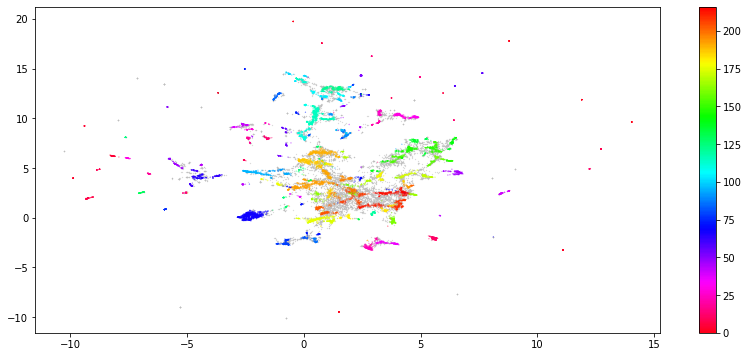

In [ ]:
fig,ax=plt.subplots(figsize=(14,6))
outliers=result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels,s=0.05,cmap='hsv_r')
plt.colorbar()
plt.show()

In [ ]:
del text_list[3931]

In [ ]:
text_set=[]
text_set.append([' '.join(i) for i in text_list])

In [ ]:
data=pd.DataFrame(text_set).T.rename(columns={0:'doc'})
data['Topic']=cluster.labels_
data['doc_id']=range(len(data))

In [ ]:
topic=data.groupby(['Topic'],as_index=False).agg({'doc':' '.join})

In [ ]:
topic

,Topic,doc
0,-1,제주 지검 백광석 살인 사건 발생 피해자 침입 사안 추가 혐의 적용 기소 경찰 피해...
1,0,삼양 동장 농작물 재해 보험 가입 당부 김학철 제주시 삼양 동장 동주 센터 민원실 ...
2,1,예수 영농 조합 법인 서귀포시 교육 전기금 모금 참여 현재 기탁 금액 예수 영농 조...
3,2,녹유 오늘 운세 목요일 음력 계묘 말띠 만남 뉴시스 개띠 무지갯빛 환상 녹유 오늘 ...
4,3,제주시 체납액 자동차세 제주 고질 자동차세 체납액 일소 체납 차량 집중 단속 장기 ...
...,...,...
213,212,고희영 감독 이번 제주 여성 영상 자서전 특유 제주 여성 시대 한계 극복 과정 영상...
214,213,프로그램 방역 수칙 운영 교육 문의 구좌읍 여성 가족 지원 센터 인근 세화 해변 마...
215,214,연구회 청년 해외 연수 취업 연계 프로그램 글로벌 청년 사업가 양성 사업 이상 수료...
216,215,양형석 도예가 강사 지도 생활 식기 시간 성인 대상 과정 운영 도서관 관계자 이번 ...


In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
import scipy.sparse as sp
from sklearn.preprocessing import normalize

In [ ]:
def c_tf_idf(doc,m,ngram_range=(1,1)):
    count=CountVectorizer(ngram_range=ngram_range).fit(doc)
    t=count.transform(doc).toarray()
    w=t.sum(axis=1)
    tf=np.divide(t.T,w)
    sum_t=t.sum(axis=0)
    idf=np.log(np.divide(m,sum_t)).reshape(-1,1)
    tf_idf=np.multiply(tf,idf)
    return tf_idf,count
ctfidf,count=c_tf_idf(topic.doc.values,m=len(data.doc))

In [ ]:
ctfidf.T.argsort()[:, -20:].shape

(218, 20)

In [ ]:
def top_n_words_topic(ctfidf, count, topic, n=20):
    words=count.get_feature_names()
    labels = list(topic.Topic)
    tf_idf_transposed = ctfidf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words
def topic_sizes(df):
    topic_sizes=(df.groupby(['Topic']).doc.count().reset_index()
                                     .rename(columns={'doc':'size'})
                                     .sort_values('size',ascending=False))
    return topic_sizes

In [ ]:
top_n_words=top_n_words_topic(ctfidf,count,topic,n=20)

In [ ]:
topic_size=topic_sizes(data)

In [ ]:
topic_size

,Topic,size
0,-1,9295
69,68,821
116,115,511
194,193,446
177,176,337
...,...,...
134,133,16
201,200,15
18,17,15
135,134,15


In [ ]:
top_n_words

{-1: [('사회', 0.008471920667175118),
  ('사업', 0.008256647247107816),
  ('지역', 0.008141422829285292),
  ('추진', 0.007984799371563829),
  ('지원', 0.007983550698079636),
  ('교육', 0.007535328782902668),
  ('이번', 0.007428607279604984),
  ('운영', 0.007328132051645993),
  ('활동', 0.00729817144261548),
  ('복지', 0.007176082979263338),
  ('서귀포시', 0.007135185165222325),
  ('코로나', 0.007115758060650893),
  ('문화', 0.006876720226220717),
  ('진행', 0.00681471365583377),
  ('환경', 0.00670567906297279),
  ('센터', 0.0066875178542413075),
  ('제주도', 0.006495220009532024),
  ('계획', 0.0062794587608615135),
  ('서귀포', 0.006219723329912292),
  ('대상', 0.006098446744440957)],
 0: [('법주', 0.16003407519941348),
  ('삼양', 0.1442640408497286),
  ('가입', 0.12439997315329301),
  ('정차', 0.12020105449304408),
  ('민원실', 0.10203083458307326),
  ('동주', 0.09701419899329469),
  ('보험', 0.0965093506149647),
  ('자연재해', 0.08889381513247555),
  ('당부', 0.08831873529047796),
  ('차량', 0.08626914346853501),
  ('지도자', 0.08225698987358289),
  ('풍

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
for i in range(10):
    similar = cosine_similarity(ctfidf.T)
    np.fill_diagonal(similar, 0)

    topic_size=data.groupby(['Topic']).count().sort_values('doc',ascending=False).reset_index()
    topic_to_merge=topic_size.iloc[-1].Topic
    topic_to_merge_into=np.argmax(similar[topic_to_merge + 1]) - 1

    data.loc[data.Topic == topic_to_merge,'Topic']=topic_to_merge_into
    old_topics=data.sort_values('Topic').Topic.unique()
    map_topics={old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    data.Topic = data.Topic.map(map_topics)
    topic=data.groupby(['Topic'],as_index=False).agg({'doc':' '.join})

    m=len(list(data))
    ctfidf,count=c_tf_idf(data.doc.values,m)
    top_n_words=top_n_words_topic(ctfidf,count,topic,n=20)

topic_size=topic_sizes(data)
topic_size

NameError: ignored